In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,norm
from scipy import interpolate
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV,train_test_split,KFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score,accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
#load data
data = pd.read_csv('feature.csv')
y = pd.read_csv('label.csv')
data = pd.merge(y, data, on='APPLICATION_ID')
y_label = y['DEFAULT_LABEL']

In [5]:
sum(y_label)

1543

In [6]:
#load test data
data_test = pd.read_csv(r'D:\22CD80\Que\data\test\feature.csv')
y_test = pd.read_csv(r'D:\22CD80\Que\data\test\label.csv')
y_labeltest = y_test['DEFAULT_LABEL']
data_test = pd.merge(y_test, data_test, on='APPLICATION_ID')

In [7]:
#missing data（前端不需要，当这个代码块不存在）
X = data.copy()
X_na = (X.isnull().sum()/ len(X)) * 100
X_na = X_na.drop(X_na[X_na<=25].index).sort_values(ascending = False)
missing_data =pd.DataFrame({'Missing Raio(%)':X_na})

In [8]:
#删除缺失25%以上的，前端也不用管
X_del = list()
X_del = X_na.index.tolist()
for i in X_del:
    data = data.drop(i,axis=1)
    data_test = data_test.drop(i,axis=1)

In [9]:
#前端print("after deleting the missing data, your dataset has 73500 rows, 378 columns left.")

In [10]:
#前端不用管
data = data.drop(['APPLICATION_ID','DEFAULT_LABEL'],axis=1)
data_test = data_test.drop(['APPLICATION_ID','DEFAULT_LABEL'],axis=1)

In [11]:
#差值填补，前端不用管
for col in data.columns.values.tolist():
    data[col] = data[col].interpolate()
for col in data.columns.values.tolist():
    data[col] = data[col].fillna(-99)
data.isnull().any() 

APPLICATION_DATE    False
v006                False
v007                False
v014                False
v017                False
                    ...  
v989                False
v990                False
v996                False
v997                False
v999                False
Length: 376, dtype: bool

In [12]:
#差值填补，前端不用管
for col in data_test.columns.values.tolist():
    data_test[col] = data_test[col].interpolate()
for col in data_test.columns.values.tolist():
    data_test[col] = data_test[col].fillna(-99)
data.isnull().any() 

APPLICATION_DATE    False
v006                False
v007                False
v014                False
v017                False
                    ...  
v989                False
v990                False
v996                False
v997                False
v999                False
Length: 376, dtype: bool

In [13]:
#prepare training dataset and testing dataset（前端不用管）
data['label']=y['DEFAULT_LABEL']
data_true = data[data['label']==1]
data_false = data[data['label']==0]
data = data.drop(['label'],axis = 1)
#sampling the inbalanced dataset
data_true_sample = data_true.sample(n=30000, replace=True, axis=0)
data_false_sample = data_false.sample(n=30000, replace=True, axis=0)
data_train = pd.concat([data_true_sample,data_false_sample],axis = 0)
y_train = data_train['label']
data_train = data_train.drop(['label'],axis = 1)

In [14]:
#model traning
from xgboost import XGBClassifier,XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb

In [15]:
def xgbclassify(trainx,trainy,testx):
    t = XGBClassifier(learning_rate=0.01,
                  n_estimators=200,
                  max_depth=4,
                  min_child_weight=0.85,
                  gamma=0,
                  subsample=0.7,
                  eval_metric='auc')
    t.fit(trainx,trainy)
    y_pre = t.predict(testx)
    probas = t.predict_proba(testx)[:,1]
    return y_pre,probas

In [16]:
y_pre= []
probas = []
y_pre , probas = xgbclassify(data_train,y_train,data_test)

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [17]:
#画ROC曲线的数据，df的第一列fpr是横轴，第二列tpr是纵轴
fpr, tpr, _ = roc_curve(y_labeltest, probas)
Roc_curve = {}
Roc_curve = {'fpr':fpr,'tpr':tpr}
df_roc = pd.DataFrame(Roc_curve)

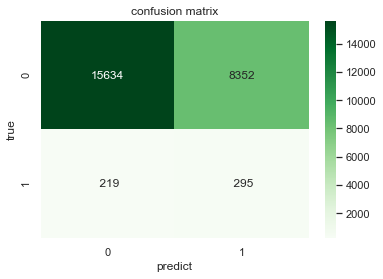

In [18]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    sns.set()
    f,ax=plt.subplots()
    sns.heatmap(cm,annot=True,ax=ax, cmap="Greens", fmt="4d") #画热力图

    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    ax.set_xticks 
    
    plt.show()

#得到混淆矩阵
cm = confusion_matrix(y_labeltest,y_pre,labels=[0,1])

#调用函数，绘制混淆矩阵图
plot_confusion_matrix(cm )

In [27]:
t = XGBClassifier(learning_rate=0.01,
                  n_estimators=200,
                  max_depth=4,
                  min_child_weight=0.85,
                  gamma=0,
                  subsample=0.7,
                  eval_metric='auc').fit(data_train,y_train)
model = SelectFromModel(t,prefit=True,threshold = 0.003)
feature_idx = model.get_support()
feature_name = data_train.columns[feature_idx]
feature_name = feature_name.tolist()

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [147]:
#画柱状图的，fplot是画图用的数据
col = list(data_train.columns)
lis = list(t.feature_importances_)
f_importance = pd.DataFrame(columns = ['col','lis'])
f_importance['col'] = col
f_importance['lis'] = lis
f_importance = f_importance.sort_values(by='lis',ascending=False)
f_plot = f_importance.iloc[0:15,:]

In [29]:
names = []
for i in feature_name:
    names.append(i)
new_model = data_train.loc[:,names]
transfer = StandardScaler()
new_model = pd.DataFrame(transfer.fit_transform(new_model))
new_model.columns = names

In [30]:
names = []
for i in feature_name:
    names.append(i)
test_new_model = data_test.loc[:,names]
transfer = StandardScaler()
test_new_model = pd.DataFrame(transfer.fit_transform(test_new_model))
test_new_model.columns = names

In [135]:
def clfclassify(trainx,trainy,testx):#这个模型和上个模型的训练集不一样，注意参数
    clf = lgb.LGBMClassifier(
        max_depth=4, n_estimators=200,subsample_freq=2,
        subsample=0.6, colsample_bytree=0.5, 
        learning_rate=0.02, min_child_weight=0.7, n_jobs=-1,min_data_in_leaf =500, scale_pos_weight=1,metric='auc'
    )
    clf.fit(trainx,trainy)
    y_pre = clf.predict(testx)
    probas = clf.predict_proba(testx)
    return y_pre,probas

In [139]:
#画新ROC曲线的数据，df的第一列fpr是横轴，第二列tpr是纵轴
fpr2, tpr2, _ = roc_curve(y_labeltest, probas)
Roc_curve2 = {}
Roc_curve2 = {'fpr2':fpr2,'tpr2':tpr2}
df_roc2 = pd.DataFrame(Roc_curve2)

In [137]:
y_pre_new = []
probas_new = []
y_pre_new , probas_new = clfclassify(new_model,y_train,test_new_model)#这个模型的参数在这里

In [138]:
roc_auc_score(y_labeltest,probas_new[:,1])

0.6582247556210644

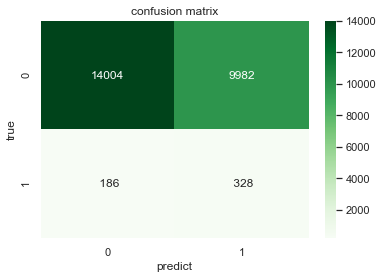

In [98]:
cm = confusion_matrix(y_labeltest,y_pre_new,labels=[0,1])

#调用函数，绘制混淆矩阵图d
plot_confusion_matrix(cm )

In [92]:
data_t = pd.read_csv(r'D:\22CD80\final_submission\feature.csv')
y_t = pd.read_csv(r'D:\22CD80\final_submission\sample_submission.csv')
data_t = pd.merge(y_t, data_t, on='APPLICATION_ID')

In [94]:
data_t = data_t.drop(['APPLICATION_ID'],axis=1)

In [95]:
X_del = list()
X_del = X_na.index.tolist()
for i in X_del:
    data_t = data_t.drop(i,axis=1)
  

In [96]:
for col in data_t.columns.values.tolist():
    data_t[col] = data_t[col].interpolate()
for col in data_t.columns.values.tolist():
    data_t[col] = data_t[col].fillna(-99)
data_t.isnull().any() 

APPLICATION_DATE    False
0                   False
1                   False
v006                False
v007                False
                    ...  
v989                False
v990                False
v996                False
v997                False
v999                False
Length: 378, dtype: bool

In [104]:
names = []
for i in feature_name:
    names.append(i)
t_new_model = data_t.loc[:,names]
transfer = StandardScaler()
t_new_model = pd.DataFrame(transfer.fit_transform(t_new_model))
t_new_model.columns = names

In [160]:
y_pre_new , probas_new = clfclassify(new_model,y_train,t_new_model)

In [161]:
probas_new = pd.DataFrame(probas_new)

In [168]:
pro = pd.DataFrame(columns = ['APPLICATION_ID','APPLICATION_DATE'])
pro['APPLICATION_ID'] = y_t['APPLICATION_ID']
pro['APPLICATION_DATE'] = y_t['APPLICATION_DATE']

In [166]:
pro = pd.merge(pro,probas_new)

,0,1,APPLICATION_ID,APPLICATION_DATE
0,0.714822,0.285178,e390d2817c393edd7d2ffb9f0938399275b1f135,44375
1,0.501957,0.498043,99b20a430100265d5668e659e0fa8b994c2f3b0e,44431
2,0.515994,0.484006,4305a9e16c17a0245bb3af1498805d1451d523b8,44456
3,0.762755,0.237245,ed0570d18e99e49d338b4510518aeb5aeb97b026,44370
4,0.594830,0.405170,c926e324c5b2f764608991638d7986ab9e2e5c5d,44356
...,...,...,...,...
2995,0.473889,0.526111,eb5481ac1f703dc860b77a86356ffeae90598a84,44426
2996,0.787901,0.212099,3d80542dce12ba1be6c91348b3bad00d8f4c8300,44386
2997,0.531993,0.468007,102565e034fbd8f93c696162e14f5ba1b32694f0,44422
2998,0.517709,0.482291,ac7b4b9a89e5128d8ec6863f35c6bb11d68c2f94,44441


In [159]:
probas_new

,APPLICATION_ID,APPLICATION_DATE,0,1


In [148]:
prob = pd.DataFrame(columns = ['APPLICATION_ID','APPLICATION_DATE','0','1'])
prob['APPLICATION_ID'] = y_t['APPLICATION_ID']
prob['APPLICATION_DATE'] = y_t['APPLICATION_DATE']
prob['0'] = L1
prob['1'] = L2
prob.to_csv('submission.csv')